## Burgers: One-pfive step Method

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
from jaxopt import GradientDescent
from functools import partial
from jax.config import config;
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers5 import *
from loss import *
from utils import *


os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
config.update("jax_enable_x64", True)

(100, 320)


In [2]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

### Cost function

Create objective function `L`

$$
L(Z_0) = f(X_N)^T \Gamma(S_N,S_N)^{-1} f(X_N) + \lambda \sum_{i=1}^m (Z_{0,i*N:(i+1)*N})^T K(X_N,X_N)^{-1}(Z_{0,i*N:(i+1)*N})
$$
where
$$
Z_0[M] = U[M].
$$

1. Get `f_gh_tr_pred` from two step to be the new `f` in the 1.5 step method.

In [3]:
# First column in Gamma(S_N,S_N)
X = X_gh_tr # (N_gh_tr*m, 2)

# Second column in Gamma(S_N,S_N)
U = U_gh_tr.reshape(N_gh_tr*m,) # (N_gh_tr*m, )

# f(X_N)
#f = f_Test(model,e_test)
f = two_step_dict['f_gh_tr_pred']

In [4]:
# Load values of U predicted from 2-step at te points: originally wrong
U_gh_tr_pred = np.load('data/U_gh_tr_pred.npy')
U_x_gh_tr_pred = np.load('data/U_x_gh_tr_pred.npy')
U_xx_gh_tr_pred = np.load('data/U_xx_gh_tr_pred.npy')
# Build Z_warm
Z_warm = jnp.array(U_gh_tr_pred.T.reshape(N_gh_tr*m,)) 

In [5]:
# # Load values of U predicted from 2-step at te points: originally wrong
# U_te_pred = np.load('data/U_te_pred.npy')
# U_x_te_pred = np.load('data/U_x_te_pred.npy')
# U_xx_te_pred = np.load('data/U_xx_te_pred.npy')
# # Build Z_warm
# Z_warm = jnp.array(U_te_pred.T.reshape(N_te*m,)) 

First iteration RKHS norm of P 

Gaussian

In [6]:
S = jnp.zeros((N_gh_tr*m, 5))

# Split Z
for i in range(m):
    Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
    optim_sgm = two_step_dict.get('optim_sgm_u')[i]
    optim_nugget = two_step_dict.get('optim_nugget_u')[i]
    G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)

    Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
    Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

    Si = jnp.vstack((X[:N_gh_tr].T, Zi, Zi_x,Zi_xx)).T
    # print shapes and values here
    S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
# Scaling S_N
scaler_s_train = MinMaxScaler()
S = scaler_s_train.fit_transform(S)
S = jnp.array(S)
# Gamma(S_N,S_N)
optim_sgm_P = two_step_dict.get('optim_sgm_P')
Gamma = K(Gaussian, S, S, optim_sgm_P)
nugget_P = two_step_dict.get('optim_nugget_P') 
Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
#print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

# (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
b = jnp.linalg.solve(Gamma,f)

rkhs_P_first_iter = jnp.dot(f.T , b)

Poly2

In [8]:
S = jnp.zeros((N_gh_tr*m, 5))

# Split Z
for i in range(m):
    Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
    optim_sgm = two_step_dict.get('optim_sgm_u')[i]
    optim_nugget = two_step_dict.get('optim_nugget_u')[i]
    G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)

    Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
    Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

    Si = jnp.vstack((X[:N_gh_tr].T, Zi, Zi_x,Zi_xx)).T
    # print shapes and values here
    S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
# Scaling S_N
scaler_s_train = MinMaxScaler()
S = scaler_s_train.fit_transform(S)
S = jnp.array(S)
# Gamma(S_N,S_N)
#optim_sgm_P = two_step_dict.get('optim_sgm_P')
Gamma = K(Polynomial,S, S, jnp.array([1,2]))
#nugget_P = two_step_dict.get('optim_nugget_P') 
Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
#print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

# (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
b = jnp.linalg.solve(Gamma,f)

rkhs_P_first_iter = jnp.dot(f.T , b)

First iteration RKHS norm of u

In [ ]:
# Second term
sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
nugget_K = two_step_dict.get('optim_nugget_u')
K_XNs = []
for i in range(m):
    K_XN = K(Gaussian,X_gh_tr[:N_gh_tr],X_gh_tr[:N_gh_tr],sigma_K[i]) 
    K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N_gh_tr))

rkhs_u_first_iter = []
for i in range(m):
    Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
    c = jnp.linalg.solve(K_XNs[i],Zi)
    rkhs_u_first_iter.append(jnp.reshape(jnp.dot(Zi.T , c),()))

In [ ]:
X_tr.shape

(50, 2)

In [ ]:
def L(Z, X, U, M, f, two_step_dict, lmbd):
    """Cost function for 1.5-step method.
    
    Args:
        Z: Vector [Z^1 Z^2 Z^3]^T. m*N
        X: List of mN points of dimension d.
        U: List of N1+N2+N3 values of functions u^(1),...u^(N).
        M: Bolean array which contains where true values reside.
        f: List of mN values of functions u^(1),...u^(N).
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function.
    Returns:
        scalar: a cost of this solution.    
    """ 

    ### Set up
    N = 20*20
    m = 2
    #print('Z:', Z)
    # Constrain the value of Z with known info
    #Z = jnp.where(M, U, Z)
    # Just use Z_warm instead of using line 21.
    # Cd + 1 = 4
    S = jnp.zeros((N_gh_tr*m, 5))
    
    # Split Z
    for i in range(m):
        Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
        optim_sgm = two_step_dict.get('optim_sgm_u')[i]
        optim_nugget = two_step_dict.get('optim_nugget_u')[i]
        G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N),Zi)

        Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
        Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

        Si = jnp.vstack((X[:N].T,Zi, Zi_x,Zi_xx)).T
        # print shapes and values here
        S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    S = jnp.array(S)
    # Gamma(S_N,S_N)
    optim_sgm_P = two_step_dict.get('optim_sgm_P')
    #Gamma = K(Gaussian, S, S, optim_sgm_P)
    Gamma = K(Polynomial,S, S, jnp.array([1,2]))
    nugget_P = two_step_dict.get('nugget_P') 
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    #L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P_train')
    L1 = jnp.dot(f.T , b) / rkhs_P_first_iter
    #print('L1: ', L1)

    # Second term
    sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
    nugget_K = two_step_dict.get('optim_nugget_u')
    K_XNs = []
    for i in range(m):
        K_XN = K(Gaussian,X[:N_gh_tr],X[:N_gh_tr],sigma_K[i]) 
        K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N_gh_tr))
    
    L2 = 0.
    
    for i in range(m):
        Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
        c = jnp.linalg.solve(K_XNs[i],Zi)
        # L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i]
        L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / rkhs_u_first_iter[i]
        #print('L2_',i+1,':',jnp.reshape(jnp.dot(Zi.T , c),()) / rkhs_u_first_iter[i])      
    return L1 + lmbd*L2
    

#### Gradient descent

Training data

In [ ]:
# First column in Gamma(S_N,S_N)
X = X_gh_tr # (N_gh_tr*m, 2)

# Second column in Gamma(S_N,S_N)
U = U_gh_tr.reshape(N_gh_tr*m,) # N*m x 1

# f(X_N)
#f = f_Test(model,e_test)
f = two_step_dict['f_gh_tr_pred']

Initial guess: `Z_warm`

In [ ]:
# Load values of U predicted from 2-step at te points: originally wrong
U_gh_tr_pred = np.load('data/U_gh_tr_pred.npy')
U_x_gh_tr_pred = np.load('data/U_x_gh_tr_pred.npy')
U_xx_gh_tr_pred = np.load('data/U_xx_gh_tr_pred.npy')
# Build Z_warm
Z_warm = jnp.array(U_gh_tr_pred.T.reshape(N_gh_tr*m,)) 

In [ ]:
lmbda = 1e-4/m

In [ ]:
L(Z_warm, X, U, M, f, two_step_dict, lmbd=lmbda)

Array(0.00010009, dtype=float64)

Initialize the grad functions with `jit` to be efficient

In [ ]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, M, f, two_step_dict, lmbda)
# Warm start here !!!

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float64[800,5])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[800,5])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[800,5])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[800,5]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f18ec315860>, in_tracers=(Traced<ShapedArray(float64[800,5]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x7f18ec2f23e0; to 'JaxprTracer' at 0x7f18ec313740>], out_avals=[ShapedArray(float64[800,5])], primitive=copy, params={}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f18ec36cc70>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

Run the gradient descent for `100` epochs

### Optimization of L

In [ ]:
# Load the warm-up
Z = np.copy(Z_warm)

In [ ]:
# solver = LBFGS(fun=L, maxiter=1000)
# res = solver.run(Z, X = X, U = U, M = M, f =f , two_step_dict=two_step_dict, lmbd=lmbda)

In [ ]:
solver = LBFGS(fun=L, maxiter=1000, linesearch='backtracking', history_size = 20)

In [ ]:
res = solver.run(Z, X = X, U = U, M = M, f =f , two_step_dict=two_step_dict, lmbd=lmbda)

In [ ]:
Z = res.params

In [ ]:
# u_t = u_train.T.reshape(N*m,1)
# # Load true gradients from 2-step
# u_x_train = np.load('data/u_x_train.npy')
# u_xx_train = np.load('data/u_xx_train.npy')
# # Build true Z
# Z_true = np.hstack([u_t, u_x_train.T.reshape(N*m,1),u_xx_train.T.reshape(N*m,1)])

In [ ]:
# Only do this for the first time - 
#Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

0. Run it for more iterations until it actually converges to a minimum!!!
1. Line search (using $p_k = - \nabla f$) using Armijo condition. Pick $\alpha_k$ such that satisfy the two Wolfe conditions. Test: Loss must always goes down here. 
2. Newton-Armijo.
3. Read Quasi-Newton algorithm in Nocedal, when the Hessian is not PD.  

In [ ]:
# # mses = []
# # S = jnp.zeros((N*m,4))
# # kernel = Gaussian
# # If trained previously use Z
# # if np.all(Z != Z_warm):
# #     Z = np.load('data/Z.npy')
# # else:
# #     Z = np.copy(Z_warm)
# Z = np.copy(Z_warm)
# learning_rate = 1e-7
# for i in range(100):
#     delta_Z = grad_Z(Z, X, U, M, f, two_step_dict, lmbda)
#     lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
#     Z -= lr * delta_Z

#     if i % 10 == 0:
#         print('iter:', i )
#         print('loss: ', L(Z, X, U, M, f, two_step_dict, lmbda))
#         #print('mse:', mse)
    
# # Save at the end of iterations
# #np.save('data/Z.npy',Z)

In [ ]:
np.all(Z_warm==Z)

Array(False, dtype=bool)

Evaluate `Z`

In [ ]:
S = jnp.zeros((N_gh_tr*m, 5))

# Split Z
for i in range(m):
    Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
    optim_sgm = two_step_dict.get('optim_sgm_u')[i]
    optim_nugget = two_step_dict.get('optim_nugget_u')[i]
    G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)
    Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
    Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)
    Si = jnp.vstack((X[:N_gh_tr].T,Zi, Zi_x,Zi_xx)).T
    S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)



# Load gradients from 2-step
U_te_pred = np.load('data/U_te_pred.npy')
U_x_te_pred = np.load('data/U_x_te_pred.npy')
U_xx_te_pred = np.load('data/U_xx_te_pred.npy')
s_train = S
s_test = np.hstack((X_te, U_te.T.reshape(-1,1), U_x_te_pred.T.reshape(-1,1), U_xx_te_pred.T.reshape(-1,1))) # (N_te*m, 5)
f_train = two_step_dict['f_gh_tr_pred']
f_test = U_t_te.T.reshape(N_te*m,1).flatten()
f_train2 = -s_train[:,2]*s_train[:,3] + 0.01*s_train[:,4]
f_test2 = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s , f_train)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

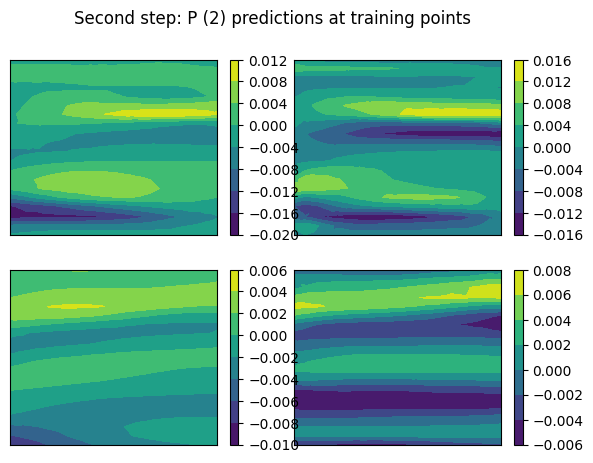

In [ ]:
# Interpolant P^* at gh_tr points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(S[i*N_gh_tr:(i+1)*N_gh_tr,0], S[i*N_gh_tr:(i+1)*N_gh_tr,1], f_pred_train[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(S[i*N_gh_tr:(i+1)*N_gh_tr,0], S[i*N_gh_tr:(i+1)*N_gh_tr,1], f_train2[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

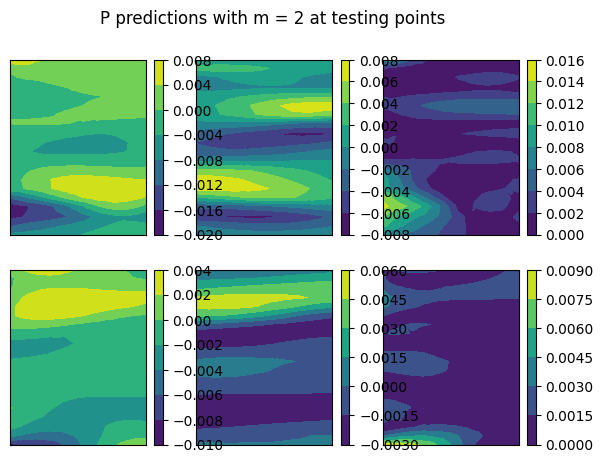

In [ ]:
# Interpolant P^* at testing points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('P predictions with m = {} at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_pred_test[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_test2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(f_test2[i*N_te:(i+1)*N_te]-f_pred_test[i*N_te:(i+1)*N_te]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [ ]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between P and P^ for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(f_train2[i*N_gh_tr:(i+1)*N_gh_tr],f_pred_train[i*N_gh_tr:(i+1)*N_gh_tr])
    n_mse_test = rel_mse(f_test2[i*N_te:(i+1)*N_te], f_pred_test[i*N_te:(i+1)*N_te])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P^ for 2 functions
m = 0 nmse_train = 0.5960164993075082
m = 0 nmse_test = 1.0703904495108947
m = 1 nmse_train = 0.6991022087248884
m = 1 nmse_test = 0.8450439190636443
